In [151]:
import math
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

class HMM:
    '''
    实现一个HMM
    
    
    假设我们有N个隐藏状态，1,2,...,N。隐藏状态0和N+1是START和STOP状态，
    只有在开头和结束的时候出现。
    
    假设我们有M个观测状态，1,2,...,M。观察状态0和M+1是为了开头和结束保留的。
    '''
    
    def __init__(self, a, b):
        '''
        初始化HMM参数
        
        用一些随机数来初始化模型参数。
        
        "a", 状态转移概率矩阵，是一个 (N+2) x (N+2)的矩阵。
        a(i, j)代表从隐状态i转变到隐状态j的概率。
        由于我们不能从任何状态回到状态0，所以a的第一列全部为0。
        同理，第N+1行也全部为0。
        
        "b", 观测生成概率矩阵，是一个(N+2) x (M+2)的矩阵。
        b(i, j)代表从隐状态i生成观测状态j的概率。
        由于观测状态0只会从隐状态0中产生，第一行只有第一列为1.0，
        其余都为0。同理，第N+1行只有第M+1列为1.0，其余都是0。
        '''
        
        
        # Check input
        if (a.shape[0] != a.shape[1] or
            a.shape[0] != b.shape[0]):
            raise Exception("Improper a or b matrix shapes.")
            
        # N is number of regular states     
        self.N = a.shape[0] - 2
        # M is number of regular outputs
        self.M = b.shape[1] - 2
        
        self.a = a
        self.b = b
        
        # Useful macros
        self.START = 0 # start state
        self.FINISH = self.N+1 # finish state
        self.STATES = range(1, self.N+1) # set of regular states
        
        # placeholders
        self.O = [] # observation sequence
        self.T = 0 # number of observations
        self.alpha_table = None
        self.beta_table = None
        self.viterbi_table = None
        self.viterbi_bpointers = None
        
    def print(self):
        print(f"N {self.N} M {self.M} T {self.T}")
        print("Transmission probabilities 'a'")
        print(self.a)
        print("Emission probabilities 'b'")
        print(self.b)
        
    def set_a_b(self, a, b):
        
        if (a.shape[0] != a.shape[1] or a.shape[0] != b.shape[0] or
            a.shape[0] != self.N+2 or b.shape[1] != self.M+2):
            raise Exception('Incompatible a, b shapes')
        
        self.a = a
        self.b = b
        self.reset_alpha_beta_tables()
        
    def reset_alpha_beta_tables(self):
        
        # intialize alpha values to save recursive calls
        self.alpha_table = np.array(
            [[-1.0] * (self.N+2)] * (self.T+2))
        self.alpha_table[self.T+1, :self.N+1] = 0.0
        self.alpha_table[0, 0] = 1.0
        self.alpha_table[0, 1:] = 0.0
        
        # initialize beta values
        self.beta_table = np.array(
            [[-1.0] * (self.N+2)] * (self.T+1)) 
        # Recall beta(T+1, i) is not defined.
        
    def set_observations(self, O):
        '''
        设置观测序列
        
        假设第一个观测是0，最后一个观测是M+1，其余是
        [1,...,M]。
        '''
        
        # Check that observations are valid
        if (not set(O[1:-1]).issubset(set(range(1, self.M+1))) or
            O[0] != 0 or O[-1] != self.M+1):
            print(O)
            raise Exception("Invalid observation sequence.")
        self.O = O
        self.T = len(O)-2
        self.reset_alpha_beta_tables()
        
    
    def forward(self):
        '''填充 alpha_table, i.e., alpha_t(j)'s'''
        
        # This should be called after set_observation, 
        # else self.T == 0.
        
        if (self.T == 0):
            raise Exception("Premature call to alpha().")
        
        # Fill t=0 values
        self.alpha_table[0, self.START] = 1.0
        for j in range(1, self.N+1):
            self.alpha_table[0, j] = 0.0
            
        # 从左往右填充alpha表格
         ##################################################
        # 你的代码 ########################################
        ##################################################
        for t in range(1, self.T + 2):  # 遍历 1 -> T + 1 时刻计算P(X_{1:t}, Z_t)
            for i in range(0, self.N + 2):  # 遍历当前时刻所有隐藏状态
                self.alpha_table[t][i] = 0.0
                for j in range(0, self.N + 2):  # 遍历前一时刻所有隐藏状态
                    # 计算转移概率
                    self.alpha_table[t][i] += self.alpha_table[t - 1][j] * self.a[j][i]
                # 计算发射概率
                self.alpha_table[t][i] *= self.b[i][self.O[t]]
        
                
    def viterbi(self, t, j):
                
        if (self.T==0 or t < 1 or t > self.T+1 or j < 0 or
            j > self.N + 1 or 
            (t == self.T+1 and j != self.FINISH)):
            raise Exception("Invalid call to viterbi().")
            
        # Check if value already available
        rv = self.viterbi_table[t, j]
        if rv <= -1:
            if t == 1:
                rv = self.a[self.START, j] * self.b[j, self.O[1]]
                self.viterbi_bpointers[t, j] = self.START
            else:
                if t == self.T+1:
                    possibles = [(self.viterbi(t-1, i) * 
                                  self.a[i,j] , i) 
                                 for i in self.STATES]
                else:             
                    possibles = [(self.viterbi(t-1, i) * 
                                  self.a[i,j] * self.b[j, self.O[t]],
                                  i)
                                 for i in self.STATES]
                    
                rv, max_i = max(possibles, key=lambda tup: tup[0])
                self.viterbi_bpointers[t, j] = max_i
            self.viterbi_table[t, j] = rv
        return rv
                
    def decode(self, obs=None):
        '''给定观测序列和self.a, self.b,
        返回最可能的hidden state序列，以及它的概率。'''
        
        seq = []
        prob = 0.0
        
        ##################################################
        # 你的代码 ########################################
        ##################################################
        # 你的代码应当实现VITERBI算法
        # 具体来说，把概率存在一张表格X中，把上一个状态的指针存在
        # 另一张表格Y中。
        # 你应该从表格Y中得到最好的隐状态序列，并计算它的概率。
        # 你会用到self.a, self.b和self.T，不过你不需要使用alpha
        # 或者beta表格。
        
        T = len(obs)  # 观测长度
        dp = np.zeros((T, self.N + 2), dtype=np.float)  # 动态规划状态
        path = -np.ones((T, self.N + 2), dtype=np.int)  # 动态规划路径
        
        dp[0][0] = 1.0  # 初始化起始状态
        for t in range(1, T):
            for i in range(self.N + 2):
                for j in range(self.N + 2):
                    temp = dp[t - 1][j] * self.a[j][i] * self.b[i][obs[t]]
                    if temp > dp[t][i]:
                        dp[t][i] = temp
                        path[t][i] = j
        
        # 计算路径
        prob = np.max(dp[T - 1])
        pos = np.argmax(dp[T - 1])
        for i in range(T - 1, -1, -1):
            seq.append(pos)
            pos = path[i][pos]
        seq = list(reversed(seq))
        return (seq, prob)
    
    def backward(self):
        '''填充beta_table beta_t(i)'''
               
        # Unlike alpha we don't define beta(T+1, i).
        # This should be called after set_observation, 
        # else self.T == 0.
        
        if (self.T == 0):
            raise Exception("Premature call to beta()")
            
        # First fill for t = T
        for i in range(1, self.N+1):
            self.beta_table[self.T, i] = self.a[i, self.FINISH]
            
        # Fill for t=1 to T-1 "recursively"
        # 从右往左填充beta表格
        for t in range(self.T-1, 0, -1): # 计算P(X_{t+1:T}|Z_t)
            ##################################################
            # 你的代码 ########################################
            ##################################################
            for i in range(1, self.N + 1):  # 遍历当前时刻所有隐藏状态
                self.beta_table[t][i] = 0.0
                for j in range(1, self.N + 1):  # 遍历后一时刻所有隐藏状态
                    self.beta_table[t][i] += (self.beta_table[t + 1][j] * 
                                              self.a[i][j] * 
                                              self.b[j][self.O[t + 1]])
        
        # Fill in for t = 0 and i = START
        self.beta_table[0, self.START] = sum(
                [self.a[self.START, j] * self.b[j,  self.O[1]] * 
                 self.beta_table[1, j] for j in self.STATES])
    
    def xi(self, t, i, j):
        '''
        Return xi_t(i, j)
        '''        

        # The basic formula works for t=0 as well. For t=T we need
        # a special case because beta(t+1, j) is not defined for all j.
                
        if self.alpha_table[self.T+1, self.FINISH] <= 0.0:
            raise Exception("Impossible observation sequence")
    
        if t >= 0 and t < self.T:
            ##################################################
            # 你的代码 ########################################
            ##################################################
            numerator = (self.alpha_table[t, i] *
                         self.a[i, j] *
                         self.b[j, self.O[t + 1]] *
                         self.beta_table[t + 1, j])
                    
            denominator = 0
            for i in range(self.N + 2):
                for j in range(self.N + 2):
                    denominator += (self.alpha_table[t, i] *
                                    self.a[i, j] *
                                    self.b[j, self.O[t + 1]] *
                                    self.beta_table[t + 1, j])
            
            rv = numerator / denominator
            
        elif t == self.T: # non-zero only for j == FINISH
            ##################################################
            # 你的代码 ########################################
            ##################################################
            numerator = (self.alpha_table[t, i] *
                         self.a[i, j] *
                         self.b[j, self.O[t + 1]])
            
            denominator = 0
            for i in range(self.N + 2):
                for j in range(self.N + 2):
                    denominator += (self.alpha_table[t, i] *
                                    self.a[i, j] *
                                    self.b[j, self.O[t + 1]])
            rv = numerator / denominator
            
        else:
            raise Exception("Invalid call to xi().")
        return rv
    
    def gamma(self, t, j):
        '''
        返回 gamma_t(j)
        '''  
        
        rv = 0
        
        ##################################################
        # 你的代码 ########################################
        ##################################################
        # 你的代码需要计算 gamma_t(j) 
        # 你会需要用到self.alpha_table, self.beta_table, 
        # self.T以及self.START, self.FINISH等等。
        if t == 0:
            rv = (1.0 if j == self.START else 0.0)
        elif t == self.T + 1:
            rv = (1.0 if j == self.FINISH else 0.0)
        else:
            rv = ((self.alpha_table[t][j] * self.beta_table[t][j]) / 
                  np.sum(self.alpha_table[t] * self.beta_table[t]))
        return rv

    def a_from_xi(self, i, j, rtype='ratio'):
        '''
        Return new a_{ij} computed from xi
        '''
    
        if j == self.START or i == self.FINISH:
            numerator = 0.0
            denominator = 1.0
        else:
            ##################################################
            # 你的代码 ########################################
            ##################################################
            numerator = 0.0
            denominator = 0.0
            for t in range(self.T + 1):
                numerator += self.xi(t, i, j)
                denominator += self.gamma(t, i)
            
            rv = numerator / denominator

        if rtype == 'separate':
            rv = (numerator, denominator)
        elif math.isclose(denominator, 0.0):
            print("Divide by zero in i={} j={}".format(i, j))
            rv = np.nan
        else:
            rv = numerator/denominator
        return rv
        
    def b_from_gamma(self, j, v, rtype='ratio'):
    
        ##################################################
        # 你的代码 ########################################
        ##################################################
        numerator = 0
        denominator = 0
        
        for t in range(self.T + 2):
            denominator += self.gamma(t, j)
            if self.O[t] == v:
                numerator += self.gamma(t, j)

        if rtype == 'separate':
            rv = (numerator, denominator)    
        elif math.isclose(denominator, 0.0):
            print("Divide by zero in j={}, v={}".format(j, v))
            rv = np.nan
        else:
            rv = numerator/denominator
        return rv
    
    def new_a(self):
        rv = np.array([[-1.0] * (self.N+2)] * (self.N+2))
        for i in range(self.N+2):
            for j in range(self.N+2):
                rv[i,j] = self.a_from_xi(i, j)
        return rv
    
    def new_b(self):
        rv = np.array([[-1.0] * (self.M+2)] * (self.N+2))
        for j in range(self.N+2):
            for v in range(self.M+2):
                rv[j,v] = self.b_from_gamma(j,v)
        return rv
    
    def fit(self, O, max_iter=10, verbose=False):
        
        self.set_observations(O)
        converged = False
        i = 0
        while not converged and i < max_iter:
            i += 1
            
            self.forward()
            self.backward()
            
            new_a = self.new_a()
            new_b = self.new_b()
            
            if verbose:
                print(f'Iteration {i}')
                print(new_a)
                print(new_b)
        
            if (np.allclose(new_a, self.a) and
                    np.allclose(new_b, self.b)):
                converged = True
            else:
                self.set_a_b(new_a, new_b)
        return(i)

In [152]:
# A toy example for testing your code, based on Jason Eisner's
# Workbook

transmission_prob = np.array([
    [0. , 0.5, 0.5, 0. ],
    [0. , 0.8, 0.1, 0.1],
    [0. , 0.2, 0.7, 0.1],
    [0. , 0. , 0. , 0. ]])

emission_prob = np.array([
    [1. , 0. , 0. , 0. , 0. ],
    [0. , 0.7, 0.2, 0.1, 0. ],
    [0. , 0. , 0.3, 0.7, 0. ],
    [0. , 0. , 0. , 0. , 1. ]])

observation_short = [
    0,
    2, 3, 3, 2,
    4
]

T_observation_short = len(observation_short) -2

observation_long = [
    0,
    2, 3, 3, 2,
    3, 2, 3, 2,
    2, 3, 1, 3,
    3, 1, 1, 1,
    2, 1, 1, 1,
    3, 1, 2, 1,
    1, 1, 2, 3,
    3, 2, 3, 2, 
    2,
    4
]

T_observation_long = len(observation_long)-2

In [153]:
hmms = HMM(transmission_prob, emission_prob)
hmms.set_observations(observation_short)
hmms.forward()
expected_alpha = np.array(
      [[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.1       , 0.15      , 0.        ],
       [0.        , 0.011     , 0.0805    , 0.        ],
       [0.        , 0.00249   , 0.040215  , 0.        ],
       [0.        , 0.002007  , 0.00851985, 0.        ],
       [0.        , 0.        , 0.        , 0.00105268]])

assert np.allclose(hmms.alpha_table, expected_alpha)

hmms.backward()
expected_beta = np.array([
    [ 0.00105268, -1.        , -1.        , -1.        ],
    [-1.        ,  0.0011457 ,  0.0062541 , -1.        ],
    [-1.        ,  0.00327   ,  0.01263   , -1.        ],
    [-1.        ,  0.019     ,  0.025     , -1.        ],
    [-1.        ,  0.1       ,  0.1       , -1.        ]])
assert np.allclose(hmms.beta_table, expected_beta)

expected_decode = ([0, 2, 2, 2, 2, 3], 0.0007563149999999998)
assert hmms.decode(hmms.O) == expected_decode

In [154]:
hmml = HMM(transmission_prob, emission_prob)
hmml.fit(observation_long, max_iter = 20, verbose=False)
expected_a = np.array([
    [0.00000000e+00, 5.68740363e-15, 1.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 9.33778559e-01, 6.62214406e-02, 1.21039999e-15],
    [0.00000000e+00, 7.18667227e-02, 8.64943927e-01, 6.31893502e-02],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
expected_b = np.array([
    [1.        , 0.        , 0.        , 0.        , 0.        ],
    [0.        , 0.64048263, 0.14806965, 0.21144771, 0.        ],
    [0.        , 0.        , 0.53439047, 0.46560953, 0.        ],
    [0.        , 0.        , 0.        , 0.        , 1.        ]])
assert np.allclose(hmml.a, expected_a)
assert np.allclose(hmml.b, expected_b)

expected_decode_result = ([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 
                           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 
                           2, 2, 2, 2, 2, 2, 3],
                          1.4779964597903278e-16)
assert np.allclose(hmml.decode(hmml.O)[0], expected_decode_result[0])
assert np.isclose(hmml.decode(hmml.O)[1], expected_decode_result[1])

In [155]:
class HMMMulti(HMM):
        
    def update_new_a_num_deno(self):
        for i in range(self.N+2):
            for j in range(self.N+2):
                (num, deno) = self.a_from_xi(i, j, 'separate')
                self.new_a_num[i,j] += num
                self.new_a_deno[i,j] += deno
    
    def update_new_b_num_deno(self):
        for j in range(self.N+2):
            for v in range(self.M+2):
                (num, deno) = self.b_from_gamma(j, v, 'separate')
                self.new_b_num[j, v] += num
                self.new_b_deno[j, v] += deno
                
    def get_likelihoods(self):
        '''在每一个fit/learning步骤中计算似然概率。
           
           假设它会在fit函数中被用到。'''
        
        prob = 0 # in log space
        self.forward()
        prob += np.log(self.alpha_table[
            self.T+1, self.FINISH])
        return np.exp(prob)


    def fit(self, Oset, max_iter=10, verbose=False):
        
        self.new_a_num = np.array([[0.0] * (self.N+2)] * (self.N+2))
        self.new_a_deno = np.array([[0.0] * (self.N+2)] * (self.N+2))
        self.new_b_num = np.array([[0.0] * (self.M+2)] * (self.N+2))
        self.new_b_deno = np.array([[0.0] * (self.M+2)] * (self.N+2))

        self.history = []
        
        converged = False
        i = 0
        
        while not converged and i < max_iter:
            i += 1
                   
            for O in Oset:
                self.set_observations(O)
                
                self.forward()
                self.backward()
            
                self.update_new_a_num_deno()
                self.update_new_b_num_deno()
            
            new_a = self.new_a_num / self.new_a_deno
            new_b = self.new_b_num / self.new_b_deno
            
            if verbose:
                print(f'Iteration {i}')
                print(new_b.T)
                print(new_a.T)
            else:
                print(f'Iteration {i}')
        
            if (np.allclose(new_a, self.a) and
                    np.allclose(new_b, self.b)):
                converged = True
            else:
                self.set_a_b(new_a, new_b)
                self.new_a_num.fill(0)
                self.new_a_deno.fill(0)
                self.new_b_num.fill(0)
                self.new_b_deno.fill(0)
            self.history.append(self.get_likelihoods())
                
        return(i)
    

In [156]:
hmmml = HMMMulti(transmission_prob, emission_prob)
hmmml.fit([observation_long]*5, max_iter = 20)
expected_a = np.array([
    [0.00000000e+00, 5.68740363e-15, 1.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 9.33778559e-01, 6.62214406e-02, 1.21039999e-15],
    [0.00000000e+00, 7.18667227e-02, 8.64943927e-01, 6.31893502e-02],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
expected_b = np.array([
    [1.        , 0.        , 0.        , 0.        , 0.        ],
    [0.        , 0.64048263, 0.14806965, 0.21144771, 0.        ],
    [0.        , 0.        , 0.53439047, 0.46560953, 0.        ],
    [0.        , 0.        , 0.        , 0.        , 1.        ]])
assert np.allclose(hmml.a, expected_a)
assert np.allclose(hmml.b, expected_b)
expected_likelihoods = [8.463524947168683e-21, 6.45760751286262e-19,
                        2.604423720662633e-18, 3.772405535111533e-18,
                        3.934445572171057e-18, 3.945375545182965e-18,
                        3.9459945227193204e-18, 3.946030509476693e-18,
                        3.946032758826868e-18, 3.946032909436204e-18,
                        3.94603292005471e-18]
assert np.allclose(hmmml.get_likelihoods(), expected_likelihoods)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12


In [157]:
import nltk
from nltk.corpus import brown

In [158]:
class POS:
    '''
        Partition given sentences, or those obtained from the brown
        corpus, equally into fit sentences and test sentences.
        For each obtain tags using nltk tagger.  Initialize "a"
        with the tags from all sentences, but with uniform
        transition probabilities.  Initialize "b" with all words
        in all sentences.  But the emission probability 
        initialization should only use the words in fit sentences.
        For each word in the fit sentence, give its most common
        tag "high" probability of emitting it.  All other words
        get a "low" probability of being emitted by a tag.  (The
        high and low values are different for each tag because of
        normalization.)
        '''
        
    def __init__(self, sents=None, category=None, 
                 num_sents=40,
                 b_bound = 1*10**(-4), 
                 tagset="universal"):
        
        if sents is None:
            self.sents = brown.sents(categories=category)[:num_sents]
            self.tagged_sents = brown.tagged_sents(
                categories=category, tagset=tagset)[:num_sents]
        else:
            self.sents = [nltk.word_tokenize(s) for s in sents]
            self.tagged_sents = [nltk.pos_tag(s, tagset = tagset)
                                 for s in self.sents]
            
        self.fsize = int(len(self.sents) * 0.5)
        self.fit_tsents = self.tagged_sents[:self.fsize]
        self.test_tsents = self.tagged_sents[self.fsize:]
        tagged_words = [tup for s in self.tagged_sents[:self.fsize] 
                        for tup in s]
        
        self.vocabulary = (['_SWORD'] + # Special observation in STAG
                      sorted(list(set([w.lower() for 
                                    s in self.sents for w in s]))) +
                      ['_FWORD']) # Special observation in FTAG
        self.M = len(self.vocabulary) # Number of distinct observations
        
        print(f'Vocabulary size {self.M}')
    
        self.tags = (['STAG'] + # Special start state
                     sorted(list(set([p[1] for s in self.tagged_sents 
                                        for p in s]))) + 
                     ['FTAG']) # Special end state
        self.N = len(self.tags) # Number of states
    
        self.w2i = dict(zip(self.vocabulary, 
                            range(len(self.vocabulary))))
        self.t2i = dict(zip(self.tags, range(len(self.tags))))
        
        # Initialize a (transition probabilities)
        #self.a = np.random.rand(self.N, self.N)
        self.a = np.ones((self.N, self.N))
        self.a[:,0] = 0.0
        self.a = self.a/(self.a.sum(axis=1).reshape(
            self.a.shape[0],1))
        self.a[-1,:] = 0.0
        
        cfd = nltk.ConditionalFreqDist((word.lower(), tag) for 
                                       (word, tag)
                                       in tagged_words)
        
        # Initialize b (emission probabilities)
        #self.b = np.random.rand(self.N, self.M)*b_random_bound
        self.b = np.ones((self.N, self.M))*b_bound
        # STAG only produces _SWORD and FTAG only produces _FWORD
        self.b[0,:] = 0.0
        self.b[:,0] = 0.0
        self.b[0,0] = 1.0
        self.b[-1,:] = 0.0
        self.b[:,-1] = 0.0
        self.b[-1, -1] = 1.0
        # Set non-trivial probability of a word being produced
        # by its most common tag
        for word in cfd.conditions():
            tag = (cfd[word].most_common(1)[0][0])
            self.setb(tag, word, 0.5)
        self.b = self.b/(self.b.sum(axis=1).reshape(self.N,1))
        
        # Initialize an HMM on oset with a, b
        self.hmm = HMMMulti(self.a.copy(), self.b.copy())
        
    def create_oset(self):
        
        self.oset = []
        for ts in self.tagged_sents:
            s, _ = split_tagged_sent(ts)
            self.oset.append(self.s2o(s))
        
    def fit(self, max_iter=10):
        
        # Create oset
        self.create_oset()
            
        # Fit the hmm 
        self.hmm.fit(self.oset, max_iter=max_iter)
        
    def test(self):
        
        for descrip, ts_set in [("fit set", self.fit_tsents), 
                                ("test set", self.test_tsents)]:        
            correct = 0
            sum_accuracy = 0
            for ts in ts_set:
                s, tag_seq = split_tagged_sent(ts)
                predicted, _ = self.decode(s)
                a = accuracy(tag_seq, predicted)
                if a == 1.0:
                    correct += 1
                sum_accuracy += a
            avg_accuracy = sum_accuracy/len(ts_set)
            correct_ratio = correct/len(ts_set)
            print(f"For {descrip}: Average accuracy = "
                  f"{avg_accuracy:.3f}," 
                  f" Totally correct ratio = " 
                  f"{correct_ratio:.3f}")
              
    def decode(self, sentence):
        if sentence[0] != 0: # Weak check if converted
            O = self.s2o(sentence)
        else:
            O = sentence.copy()
        state_seq, prob = self.hmm.decode(O)
        tag_seq = [self.tags[s] for s in state_seq]
        return (tag_seq, prob)
        
    def setb(self, j, w, p):
        self.b[self.t2i[j], self.w2i[w]] = p
    def getb(self, j, w, b=None):
        if b is None:
            b = self.b
        return b[self.t2i[j], self.w2i[w]]
    def seta(self, i, j, p):
        self.a[self.t2i[i], self.t2i[j]] = p
    def geta(self, i, j, a=None):
        if a is None:
            a = self.a
        return a[self.t2i[i], self.t2i[j]]
    def s2o(self, sentence):
        return([0] + 
               [self.w2i[w.lower()] for w in sentence] + 
               [self.w2i['_FWORD']])
    def i2t(self, state_sequence):
        return [self.tags[i] for i in state_sequence][1:-1]
    
    def print_b_unsorted(self, b=None):
        if b is None:
            b = self.b
        for t in self.tags:
            print(f'\n\n{t}', end='')
            for w in self.vocabulary:
                p = self.getb(t, w, b)
                if p > 10**(-5):
                    print(f' {w}[{p:.5f}]', end='')
                    
    def print_a_unsorted(self, a=None):
        if a is None:
            a = self.a
        for t in self.tags:
            print(f'\n\n{t}', end='')
            for u in self.tags:
                p = self.geta(t, u, a)
                print(f' {u}[{p:.5f}]', end='')
                
    def print_b(self, b=None):
        if b is None:
            b = self.b
        for t in self.tags:
            ptups = zip(b[self.t2i[t],:],self.vocabulary)
            ptups = sorted(ptups, key = lambda tup: tup[0],
                          reverse = True) 
            print(f'\n\n{t}', end='')
            for tup in ptups:
                print(f' {tup[1]}[{tup[0]}]', end='')
                
    def print_a(self, a=None):
        if a is None:
            a = self.a
        for t in self.tags:
            ptups = zip(a[self.t2i[t],:],self.tags)
            ptups = sorted(ptups, key = lambda tup: tup[0],
                          reverse = True) 
            print(f'\n\n{t}', end='')
            for tup in ptups:
                print(f' {tup[1]}[{tup[0]}]', end='')
                
    def create_tagged_sent(self, sentence, tags):
        if sentence[0] != '_SWORD':
            s = (['_SWORD'] + 
                 [w.lower() for w in sentence] + 
                 ['_FWORD'])
        else:
            s = sentence
        return list(zip(s, tags))
    
    def check_sent(self, sentence_number):
        n = sentence_number
        s = self.sents[n]
        tag_seq = [tag for (word, tag) in 
                             self.tagged_sents[n]]
        predicted_tag_seq = self.decode(s)[0][1:-1]
        return list(zip(s, tag_seq, predicted_tag_seq))

def split_tagged_sent(tagged_sent):
    return list(zip(*tagged_sent))

def accuracy(tag_seq, predicted_tag_seq):
    if predicted_tag_seq[0] == 'STAG':
        p = predicted_tag_seq[1:-1]
    else:
        p = predicted_tag_seq
    return (sum(t == pt for (t, pt) in zip(tag_seq, p))/
            len(tag_seq))


* 在下面的样例中，HMM词性标注的效果不错，这个应该是因为所有的句子的真实词性顺序都是相同的，在这种情况下模型很容易估计参数

Vocabulary size 19
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
For fit set: Average accuracy = 1.000, Totally correct ratio = 1.000
For test set: Average accuracy = 1.000, Totally correct ratio = 1.000


STAG NOUN[1.0] STAG[0.0] .[0.0] DET[0.0] VERB[0.0] FTAG[0.0]

. FTAG[1.0] STAG[0.0] .[0.0] DET[0.0] NOUN[0.0] VERB[0.0]

DET NOUN[0.999999999999643] DET[3.570434096532293e-13] .[1.2934118864045451e-172] STAG[0.0] VERB[0.0] FTAG[0.0]

NOUN .[0.5] VERB[0.5] NOUN[7.187673012965845e-188] STAG[0.0] DET[0.0] FTAG[0.0]

VERB DET[0.5000000000000893] VERB[0.49999999999991074] NOUN[9.080572013833397e-270] STAG[0.0] .[0.0] FTAG[0.0]

FTAG STAG[0.0] .[0.0] DET[0.0] NOUN[0.0] VERB[0.0] FTAG[0.0]

STAG _SWORD[1.0] .[0.0] a[0.0] an[0.0] apple[0.0] back[0.0] bill[0.0] eat[0.0] essay[0.0] janet[0.0] mary[0.0] mile[0.0] richard[0.0] run[0.0] sam[0.0] the[0.0] will[0.0] write[0.0] _FWORD[0.0]

. .[1.0] _SWORD[0.0] a

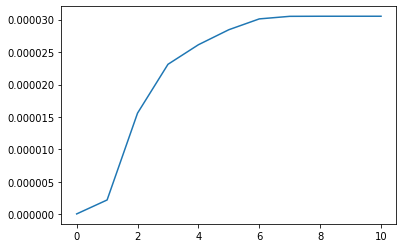

In [159]:
sents_example_1 = [
    "Janet will back the bill.",
    "Richard will eat an apple.",
    "Mary will run a mile.",
    "Sam will write an essay.",
]

start = time.time()
pos = POS(sents_example_1)
pos.fit(100)
pos.test()
pos.print_a(pos.hmm.a)
pos.print_b(pos.hmm.b)
finish = time.time()
elapsed = finish - start
print("time elapsed: ", elapsed)

plt.plot(pos.hmm.history)
plt.show()

############################################################
# 回答以下问题:  #############################################
############################################################
# 基于HMM的POS tagger模型效果如何？如果效果不好的话，会是因为什么原
# 因？

* 在第二个案例中，模型的表现就不是很好了，没有一个句子全部预测正确
* 这个我想主要问题在于两个方面
    * 一阶马尔科夫假设：当前隐状态只和前一个时刻的隐状态相关，序列标注问题不仅和单个词相关，而是和整个观测序列的长度，上下文信息等都相关。
    * 目标函数跟实际情况不符：HMM中学到的是状态与观测的联合分布P(X, Z)，而在预测问题中我们更关心条件概率P(Z|X)

Vocabulary size 30
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
For fit set: Average accuracy = 0.708, Totally correct ratio = 0.000
For test set: Average accuracy = 0.708, Totally correct ratio = 0.000


STAG NOUN[1.0] STAG[0.0] .[0.0] DET[0.0] VERB[0.0] FTAG[0.0]

. FTAG[1.0] STAG[0.0] .[0.0] DET[0.0] NOUN[0.0] VERB[0.0]

DET .[0.5000000000040954] DET[0.49999999999590455] VERB[2.697009631837366e-284] STAG[0.0] NOUN[0.0] FTAG[0.0]

NOUN VERB[1.0] STAG[0.0] .[0.0] DET[0.0] NOUN[0.0] FTAG[0.0]

VERB DET[0.9999999999836184] VERB[1.6381608821185253e-11] STAG[0.0] .[0.0] NOUN[0.0] FTAG[0.0]

FTAG STAG[0.0] .[0.0] DET[0.0] NOUN[0.0] VERB[0.0] FTAG[0.0]

STAG _SWORD[1.0] .[0.0] a[0.0] an[0.0] apple[0

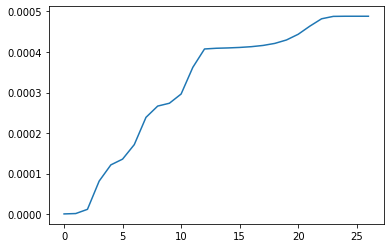

In [160]:
sents_example_2 = [
    "Janet will back the bill.",
    "Janet likes music.",
    "Richard will eat an apple.",
    "Peter needs rest.",
    "Mary will run a mile.",
    "Joe hates TV.",
    "Sam will write an essay.",
    "Ramona loves cooking.",
]

start = time.time()
pos = POS(sents_example_2)
pos.fit(100)
pos.test()
pos.print_a(pos.hmm.a)
pos.print_b(pos.hmm.b)
finish = time.time()
elapsed = finish - start
print("time elapsed: ", elapsed)

plt.plot(pos.hmm.history)
plt.show()

############################################################
# 回答以下问题:  #############################################
############################################################
# 基于HMM的POS tagger模型效果如何？如果效果不好的话，会是因为什么原
# 因？